In [1]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from qspectro2d.config import *
from qspectro2d.spectroscopy.calculations import (
    parallel_compute_1d_E_with_inhomogenity,
    check_the_solver,
    complex_polarization,
    compute_pulse_evolution,
    _compute_next_start_point,
    compute_1d_polarization,
    extract_ift_signal_component,
    _ensure_valid_times

)
from qspectro2d.spectroscopy import compute_2d_fft_wavenumber

from qspectro2d.visualization import (
    plot_example_evo,
    plot_example_polarization,
    plot_2d_el_field,
)

from qspectro2d.utils import (
    save_data_file,
    save_info_file,
    generate_unique_data_filename,
    get_max_workers,
    print_simulation_summary,
    create_base_sim_oqs
)
from qspectro2d.core.simulation_class import (
    BathSystem,
    AtomicSystem,
    LaserPulseSequence,
    SimulationConfig,
    SimulationModuleOQS,
)

def run_single_t_coh_with_sim(
    sim_oqs: SimulationModuleOQS,
    t_coh: float,
    save_info: bool = False,
    time_cut: float = -np.inf,
) -> Path:
    """
    Run a single 1D simulation for a specific coherence time using existing SimulationModuleOQS.

    Parameters:
        sim_oqs (SimulationModuleOQS): Pre-configured simulation instance
        t_coh (float): Coherence time between 2 pump pulses [fs]
        save_info (bool): Whether to save simulation info
        time_cut (float): Time cutoff for solver validation

    Returns:
        Path: absolute path to the saved data directory
    """
    print(f"\n=== Starting t_coh = {t_coh:.2f} fs ===")

    # Update t_coh in the simulation config
    sim_oqs.simulation_config.t_coh = t_coh
    t_wait = sim_oqs.simulation_config.t_wait
    sim_oqs.laser.update_delays = [t_coh, t_wait]

    start_time = time.time()

    # Run the simulation
    print("Computing 1D polarization with parallel processing...")
    try:
        data = parallel_compute_1d_E_with_inhomogenity(
            sim_oqs=sim_oqs,
            time_cut=time_cut,
        )
        print("✅ Parallel computation completed successfully!")
    except Exception as e:
        print(f"❌ ERROR: Simulation failed: {e}")
        raise

    # Save data
    simulation_config_dict = sim_oqs.simulation_config.to_dict()
    abs_path = Path(
        generate_unique_data_filename(sim_oqs.system, simulation_config_dict)
    )
    abs_data_path = Path(f"{abs_path}_data.npz")
    print(f"\nSaving data to: {abs_data_path}")

    save_data_file(abs_data_path, data, sim_oqs.times_det)

    if save_info:
        # all_infos_as_dict = sim_oqs.to_dict() TODO update the saving to incorporate all the info data in one dict?
        abs_info_path = Path(f"{abs_path}_info.pkl")
        save_info_file(
            abs_info_path,
            sim_oqs.system,
            bath=sim_oqs.bath,
            laser=sim_oqs.laser,
            info_config=simulation_config_dict,
        )

        print(f"{'='*60}")
        print(f"\n🎯 To plot this data, run:")
        print(f'python plot_datas.py --abs_path "{abs_path}"')

    elapsed = time.time() - start_time
    print_simulation_summary(elapsed, data, abs_path, "1d")

    return abs_path




In [2]:
from types import SimpleNamespace
args = SimpleNamespace(t_coh=5, t_wait=0.0, t_det_max=300.0, dt=0.05)

sim_oqs, time_cut = create_base_sim_oqs(args)

# Run single simulation
# abs_path = run_single_t_coh_with_sim(
#     sim_oqs, args.t_coh, save_info=True, time_cut=time_cut
# )

🔧 Creating base simulation configuration...
🔍 Validating solver...


/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/qutip/utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


Transition frequency w_0: 3.013918328147904
decay constant: 0.0006111484551268465, S at w_0: 0.018180707188084035
deph constant: 0.0018334453653805396, S at w_0: 0.0545421215642521


/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/qutip/utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)
/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


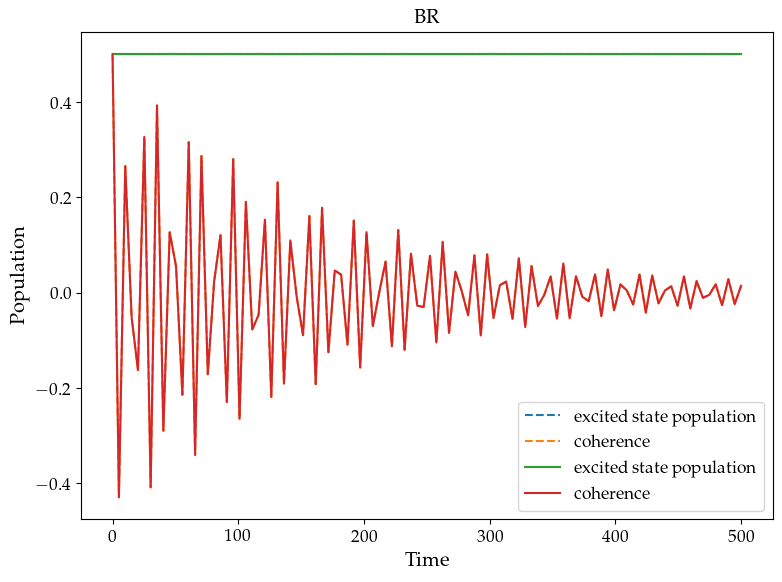

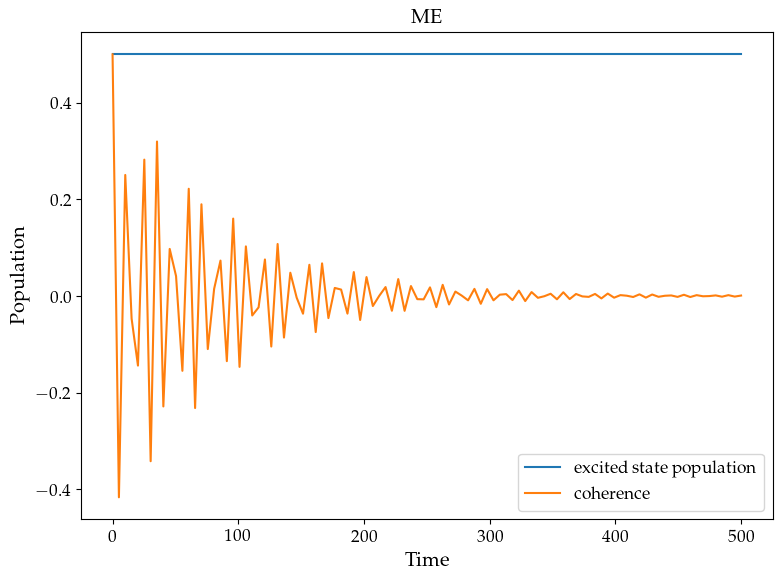

In [18]:
from math import exp

from pyparsing import line
from qspectro2d.core.system_bath_class import *
from qutip import mesolve, brmesolve, basis, expect, ket2dm
sys = AtomicSystem(
    n_atoms=1,
    psi_ini= (basis(2, 1)+basis(2, 0)).unit(),  # initially excited state
)
bath = BathSystem(
    bath="ohmic",
    temp=1e-4,
    cutoff_ = 1e1,
)

sb_coupling = SystemBathCoupling(
    system=sys,
    bath=bath,
)


coupling_const_decay = sb_coupling.coupling(bath.gamma_0, 0)
coupling_const_deph = sb_coupling.coupling(bath.gamma_phi, 0)
S = bath.power_spectrum_func
w_0 = sys.freqs_fs(0)
args_decay = sb_coupling.args_bath(alpha=bath.gamma_0, i=0)
args_deph = sb_coupling.args_bath(alpha=bath.gamma_phi, i=0)
S_at_w_0_decay = S(w_0, args_decay)
S_at_w_0_deph = S(w_0, args_deph)

print(f"Transition frequency w_0: {w_0}")
print(f"decay constant: {coupling_const_decay}, S at w_0: {S_at_w_0_decay}")
print(f"deph constant: {coupling_const_deph}, S at w_0: {S_at_w_0_deph}")
w_max = 1000  # maximum frequency for the power spectrum
w = np.linspace(-w_max/10, w_max, 1000)  # frequency range for the power spectrum

"""
plt.figure()
plt.plot(w, S(w, args_decay), label='power spectrum for decay')
plt.axvline(x=S_at_w_0_decay, color='r', linestyle='--', label=f'at sys freq: {S_at_w_0_decay:.4f} fs')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()
"""

tlist = np.linspace(0, 500, 100)  # time list for the simulation
res = brmesolve(
    sys.H0_N_canonical,
    sys.psi_ini,
    tlist,
    sb_coupling.br_decay_channels,
)
res_1 = brmesolve(
    sys.H0_N_canonical,
    sys.psi_ini,
    tlist,
    a_ops=[
        [ket2dm(sys.basis[1]), ConstantSpectrum(bath.Gamma)],
        #[sys.dip_op, lambda w: S(w, args_decay)], 
    ],
)
res_2 = mesolve(
    sys.H0_N_canonical,
    sys.psi_ini,
    tlist,
    c_ops=sb_coupling.me_decay_channels
)
plt.figure()
#plt.plot(tlist, expect(ket2dm(sys.basis[0]), res.states), label='ground state population')
plt.plot(tlist, expect(ket2dm(sys.basis[1]), res.states), linestyle='--', label='excited state population')
plt.plot(tlist, expect(sys.basis[0] * sys.basis[1].dag(), res.states), linestyle='--', label='coherence')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('BR')
plt.legend()
#plt.plot(tlist, expect(ket2dm(sys.basis[0]), res_1.states), label='ground state population')
plt.plot(tlist, expect(ket2dm(sys.basis[1]), res_1.states), label='excited state population')
plt.plot(tlist, expect(sys.basis[0] * sys.basis[1].dag(), res_1.states), label='coherence')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.figure()
#plt.plot(tlist, expect(ket2dm(sys.basis[0]), res_2.states), label='ground state population')
plt.plot(tlist, expect(ket2dm(sys.basis[1]), res_2.states), label='excited state population')
plt.plot(tlist, expect(sys.basis[0] * sys.basis[1].dag(), res_2.states), label='coherence')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('ME')
plt.legend()

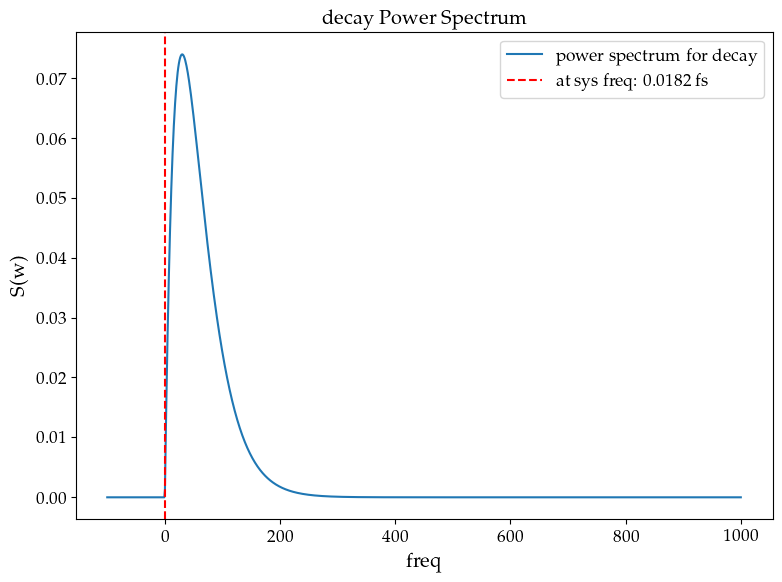

In [4]:
from functools import partial
S = partial(bath.power_spectrum_func, args=args_decay)
S_values = [S(w_val) for w_val in w]
plt.figure()
plt.plot(w, S_values, label='power spectrum for decay')
plt.axvline(x=S_at_w_0_decay, color='r', linestyle='--', label=f'at sys freq: {S_at_w_0_decay:.4f} fs')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()


/tmp/ipykernel_100121/3942144807.py:64: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_100121/3942144807.py:77: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_100121/3942144807.py:82: RuntimeWarning: overflow encountered in exp
  n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)


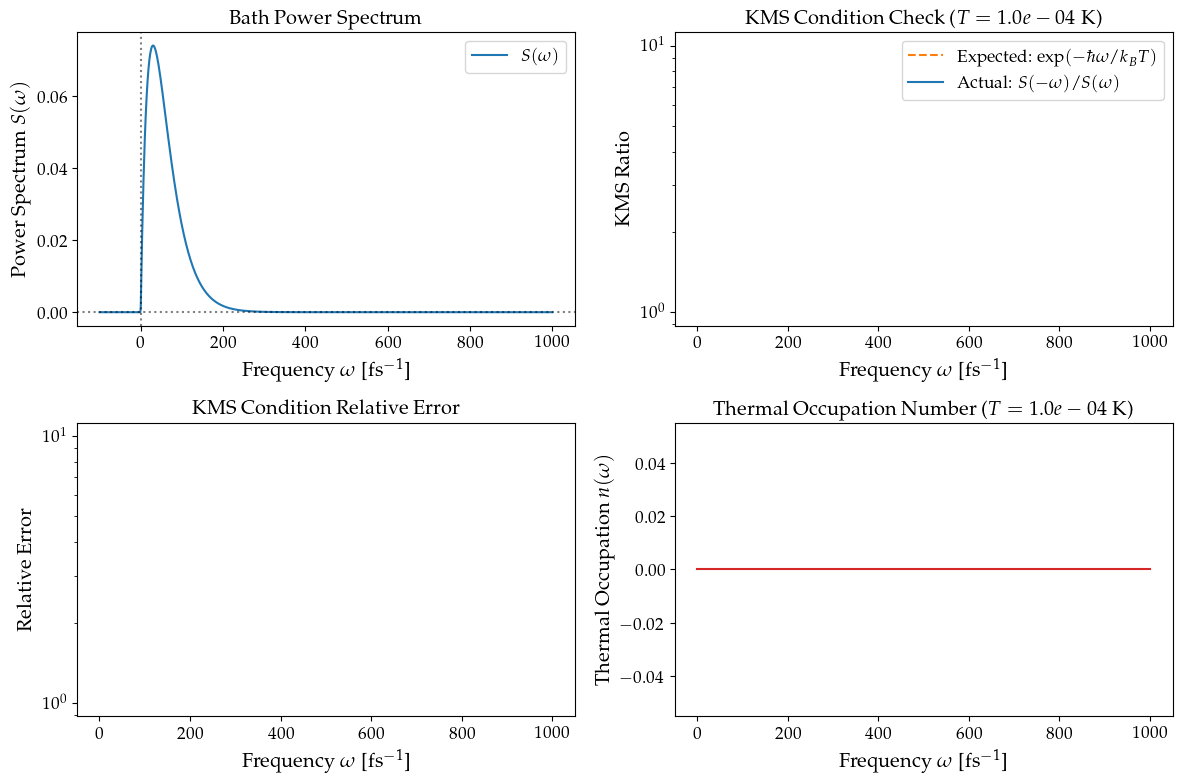


DETAILED BALANCE / KMS CONDITION CHECK
Bath temperature: 1.00e-04 K
Thermal energy kT: 1.00e-04 eV
Bath type: ohmic
Maximum relative error: 0.00e+00
Mean relative error: 0.00e+00
✅ KMS condition is satisfied (error < 1e-6)


In [5]:
# =============================
# DETAILED BALANCE / KMS CONDITION CHECK
# =============================

def check_detailed_balance_condition(
    bath: BathSystem, 
    sb_coupling: SystemBathCoupling, 
    w_range: np.ndarray
) -> None:
    """
    Check if the power spectrum satisfies the detailed balance (KMS) condition.
    
    The KMS condition states: S(-ω) = S(ω) * exp(-ħω/kT)
    For zero temperature: S(-ω) = 0 for ω > 0
    """
    
    ### Bath parameters
    args_decay = sb_coupling.args_bath(alpha=bath.gamma_0, i=0)
    S          = bath.power_spectrum_func
    kT         = BOLTZMANN * bath.temp  # thermal energy
    
    ### Evaluate power spectrum at positive and negative frequencies
    S_positive = np.array([S(w, args_decay) for w in w_range if w > 0])
    S_negative = np.array([S(-w, args_decay) for w in w_range if w > 0])
    w_positive = w_range[w_range > 0]
    
    ### Expected ratio from KMS condition
    if bath.temp > 1e-10:  # finite temperature
        kms_ratio_expected = np.exp(-HBAR * w_positive / kT)
    else:  # zero temperature limit
        kms_ratio_expected = np.zeros_like(w_positive)
    
    ### Actual ratio from power spectrum
    with np.errstate(divide='ignore', invalid='ignore'):
        kms_ratio_actual = S_negative / S_positive
        kms_ratio_actual = np.where(S_positive == 0, 0, kms_ratio_actual)
    
    ### Plot comparison
    plt.figure(figsize=(12, 8))
    
    ### Power spectrum vs frequency
    plt.subplot(2, 2, 1)
    plt.plot(w_range, [S(w, args_decay) for w in w_range], 
             label=r'$S(\omega)$', color='C0', linestyle='solid')
    plt.axhline(y=0, color='k', linestyle='dotted', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle='dotted', alpha=0.5)
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Power Spectrum $S(\omega)$')
    plt.title(r'Bath Power Spectrum')
    plt.legend()
    
    ### KMS ratio comparison
    plt.subplot(2, 2, 2)
    plt.plot(w_positive, kms_ratio_expected, 
             label=r'Expected: $\exp(-\hbar\omega/k_BT)$', 
             color='C1', linestyle='dashed')
    plt.plot(w_positive, kms_ratio_actual, 
             label=r'Actual: $S(-\omega)/S(\omega)$', 
             color='C0', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'KMS Ratio')
    plt.title(f'KMS Condition Check ($T = {bath.temp:.1e}$ K)')
    plt.legend()
    plt.yscale('log')
    
    ### Relative error
    plt.subplot(2, 2, 3)
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.abs(kms_ratio_actual - kms_ratio_expected) / np.abs(kms_ratio_expected)
        relative_error = np.where(kms_ratio_expected == 0, 
                                np.abs(kms_ratio_actual), relative_error)
    
    plt.plot(w_positive, relative_error, color='C2', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Relative Error')
    plt.title(r'KMS Condition Relative Error')
    plt.yscale('log')
    
    ### Thermal occupation number
    plt.subplot(2, 2, 4)
    if bath.temp > 1e-10:
        n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)
        plt.plot(w_positive, n_thermal, color='C3', linestyle='solid')
        plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
        plt.ylabel(r'Thermal Occupation $n(\omega)$')
        plt.title(f'Thermal Occupation Number ($T = {bath.temp:.1e}$ K)')
    else:
        plt.text(0.5, 0.5, 'Zero Temperature\n($T \\rightarrow 0$)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Thermal Occupation Number')
    
    plt.tight_layout()
    plt.show()
    
    ### Print numerical assessment
    print(f"\n{'='*50}")
    print(f"DETAILED BALANCE / KMS CONDITION CHECK")
    print(f"{'='*50}")
    print(f"Bath temperature: {bath.temp:.2e} K")
    print(f"Thermal energy kT: {kT:.2e} eV")
    print(f"Bath type: {bath.bath}")
    
    if bath.temp > 1e-10:
        max_error = np.max(relative_error[np.isfinite(relative_error)])
        mean_error = np.mean(relative_error[np.isfinite(relative_error)])
        print(f"Maximum relative error: {max_error:.2e}")
        print(f"Mean relative error: {mean_error:.2e}")
        
        if max_error < 1e-6:
            print("✅ KMS condition is satisfied (error < 1e-6)")
        elif max_error < 1e-3:
            print("⚠️  KMS condition approximately satisfied (error < 1e-3)")
        else:
            print("❌ KMS condition NOT satisfied (error > 1e-3)")
    else:
        zero_temp_satisfied = np.all(S_negative < 1e-10)
        print(f"Zero temperature condition S(-ω) ≈ 0: {zero_temp_satisfied}")
        if zero_temp_satisfied:
            print("✅ Zero temperature KMS condition satisfied")
        else:
            print("❌ Zero temperature KMS condition NOT satisfied")

# Run the check
check_detailed_balance_condition(bath, sb_coupling, w)

RWA_SL: True


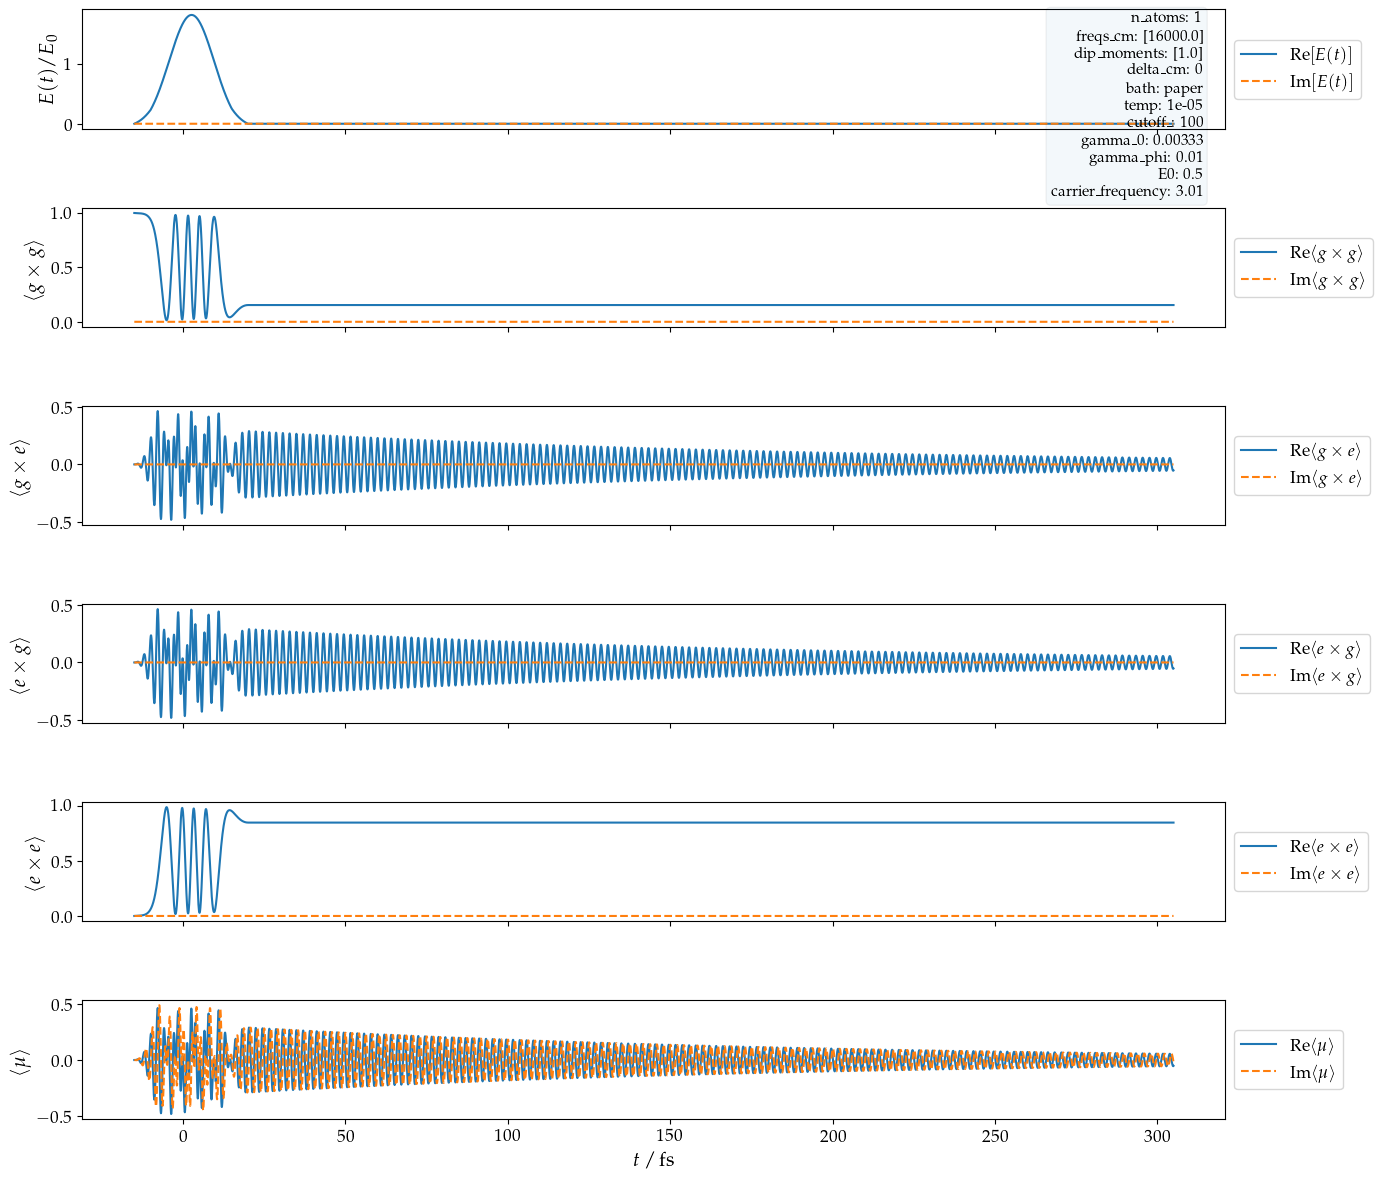

In [6]:
times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True)
rwa_sl = sim_oqs.simulation_config.rwa_sl
print(f"RWA_SL: {rwa_sl}")
system = sim_oqs.system
bath = sim_oqs.bath
laser = sim_oqs.laser
laser_dict = {k: v for k, v in laser.to_dict().items() if k != "pulses"}  # Exclude "pulses" key
dict_combined = {**system.to_dict(), **bath.to_dict(), **laser_dict}

plot_example_evo(times, datas, sim_oqs.laser, rwa_sl=rwa_sl, observable_strs=sim_oqs.observable_strs, **dict_combined)

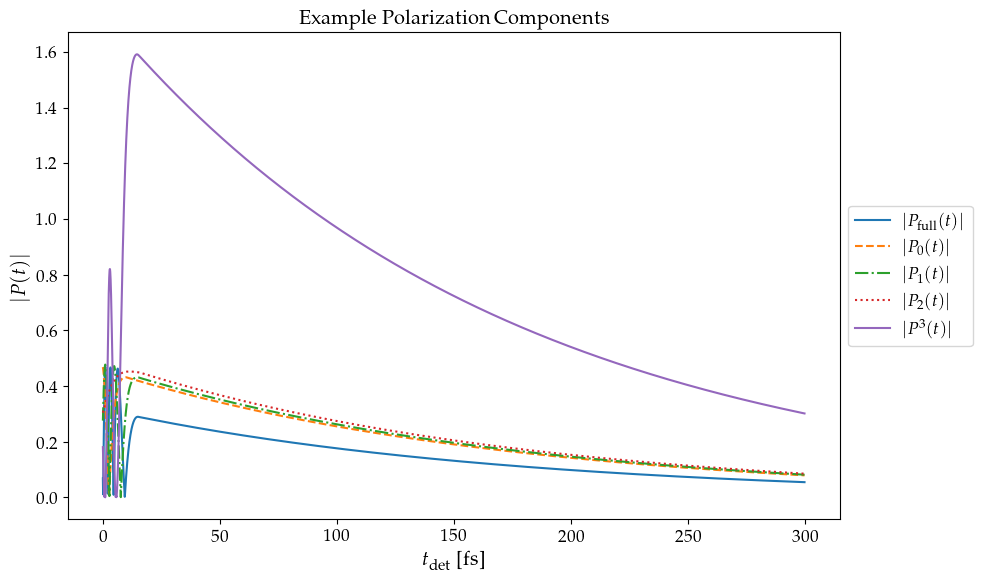

In [7]:
plot_data = compute_1d_polarization(sim_oqs, time_cut=time_cut, plot_example_polarization = True)
P_full, P_only0, P_only1, P_only2 = plot_data
times = sim_oqs.times_det

pulse_seq = sim_oqs.laser
rwa_sl = sim_oqs.simulation_config.rwa_sl
observable_strs = sim_oqs.observable_strs

plot_example_polarization(times, P_full, P_only0, P_only1, P_only2)

In [8]:
# =============================
# TEST: extract_ift_signal_component function
# =============================

### Test the IFT signal component extraction function
print("Testing extract_ift_signal_component function...")

# Create test phase array and results matrix
phases = [0, np.pi/2, np.pi, 3*np.pi/2]  # Standard phase cycling
n_phases = len(phases)

# Create test data - simulate phase-cycled results
test_times = np.linspace(0, 50, 100)
dt_test = test_times[1] - test_times[0]

print(f"Test times shape: {test_times.shape}")
print(f"Time step dt: {dt_test:.3f}")
print(f"Number of phases: {n_phases}")

# Generate synthetic phase-cycled data
results_matrix = np.zeros((n_phases, n_phases), dtype=object)

for phi1_idx, phi_1 in enumerate(phases):
    for phi2_idx, phi_2 in enumerate(phases):
        # Create complex signal with phase-dependent amplitude
        base_signal = np.exp(1j * 0.1 * test_times)  # Base oscillation
        phase_modulation = np.exp(1j * (phi_1 + phi_2))  # Phase modulation
        
        # Add some realistic features
        envelope = np.exp(-0.02 * test_times)  # Decay envelope
        noise = 0.05 * (np.random.randn(len(test_times)) + 1j * np.random.randn(len(test_times)))
        
        results_matrix[phi1_idx, phi2_idx] = (base_signal * phase_modulation * envelope + noise)

print(f"Results matrix shape: {results_matrix.shape}")
print(f"Each element shape: {results_matrix[0, 0].shape}")

try:
    # Test different signal components
    test_components = [
        [-1, 1, 0],   # Common component in 2D spectroscopy
        [1, -1, 0],   # Another common component
        [0, 0, 0],    # Zero component (should give average)
        [1, 1, 0],    # Positive component
        [-1, -1, 0],  # Negative component
    ]
    
    for component in test_components:
        print(f"\n--- Testing component {component} ---")
        
        # Extract IFT signal component
        extracted_signal = extract_ift_signal_component(
            results_matrix=results_matrix,
            phases=phases,
            component=component
        )
        
        print(f"Extracted signal shape: {extracted_signal.shape}")
        print(f"Signal type: {type(extracted_signal)}")
        print(f"Signal dtype: {extracted_signal.dtype}")
        print(f"Max amplitude: {np.max(np.abs(extracted_signal)):.4f}")
        print(f"Mean amplitude: {np.mean(np.abs(extracted_signal)):.4f}")
        
        # Check if signal is complex
        if np.iscomplexobj(extracted_signal):
            print(f"Real part range: [{np.min(np.real(extracted_signal)):.4f}, {np.max(np.real(extracted_signal)):.4f}]")
            print(f"Imag part range: [{np.min(np.imag(extracted_signal)):.4f}, {np.max(np.imag(extracted_signal)):.4f}]")
        
        # Verify the extracted signal has the same length as input
        if len(extracted_signal) == len(test_times):
            print("✓ Output length matches input length")
        else:
            print(f"❌ Length mismatch: expected={len(test_times)}, got={len(extracted_signal)}")
    
    print(f"\n{'='*50}")
    print("✅ extract_ift_signal_component function tests completed successfully!")
    
except Exception as e:
    print(f"❌ ERROR testing extract_ift_signal_component: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

Testing extract_ift_signal_component function...
Test times shape: (100,)
Time step dt: 0.505
Number of phases: 4
Results matrix shape: (4, 4)
Each element shape: (100,)

--- Testing component [-1, 1, 0] ---
Extracted signal shape: (100,)
Signal type: <class 'numpy.ndarray'>
Signal dtype: complex64
Max amplitude: 0.7130
Mean amplitude: 0.2515
Real part range: [-0.5150, 0.4167]
Imag part range: [-0.7118, 0.4793]
✓ Output length matches input length

--- Testing component [1, -1, 0] ---
Extracted signal shape: (100,)
Signal type: <class 'numpy.ndarray'>
Signal dtype: complex64
Max amplitude: 0.6134
Mean amplitude: 0.2580
Real part range: [-0.5776, 0.4452]
Imag part range: [-0.5385, 0.3977]
✓ Output length matches input length

--- Testing component [0, 0, 0] ---
Extracted signal shape: (100,)
Signal type: <class 'numpy.ndarray'>
Signal dtype: complex64
Max amplitude: 0.6342
Mean amplitude: 0.2599
Real part range: [-0.5395, 0.4782]
Imag part range: [-0.5091, 0.4207]
✓ Output length matche

In [9]:

# Additional test: Test with identical data (should give zero for non-zero components)
print(f"\n--- Testing with identical data (debugging phase cycling issue) ---")
try:
    # Create test matrix where all elements are identical (simulating your issue)
    identical_signal = np.array([1+1j, 2+2j, 3+3j, 4+4j])
    identical_matrix = np.zeros((n_phases, n_phases), dtype=object)
    
    for i in range(n_phases):
        for j in range(n_phases):
            identical_matrix[i, j] = identical_signal.copy()
    
    print("Testing identical data with component [-1, 1, 0]:")
    result_identical = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[-1, 1, 0]
    )
    
    print(f"Result with identical data: {result_identical}")
    print("This should be close to zero because all phase combinations are identical!")
    
    # Test with component [0, 0, 0] - should give the average
    print("\nTesting identical data with component [0, 0, 0]:")
    result_average = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[0, 0, 0]
    )
    print(f"Result with [0,0,0] component: {result_average}")
    print("This should equal the original signal (average of identical elements)")
    
except Exception as e:
    print(f"Identical data test failed: {e}")
    import traceback
    traceback.print_exc()
    

print("\n🔍 IFT signal component extraction testing complete!")


--- Testing with identical data (debugging phase cycling issue) ---
Testing identical data with component [-1, 1, 0]:
Result with identical data: [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
This should be close to zero because all phase combinations are identical!

Testing identical data with component [0, 0, 0]:
Result with [0,0,0] component: [16.+16.j 32.+32.j 48.+48.j 64.+64.j]
This should equal the original signal (average of identical elements)

🔍 IFT signal component extraction testing complete!


In [10]:
from copy import deepcopy
local_sim_oqs = deepcopy(sim_oqs)
test_time = local_sim_oqs.simulation_config.t_coh  # Time when second pulse is active
bphases1 = sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in sim_oqs.laser.pulses]
H_a = sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("BEFORE Laser pulse phases:", bphases1, bphases2)
local_sim_oqs = deepcopy(sim_oqs)

# DEBUG: Check phases before and after update
phi1, phi2, DETECTION_PHASE = 3, 3, 0
local_sim_oqs.laser.update_phases(
    phases=[phi1, phi2, DETECTION_PHASE]
)  # Update the laser phases in the local copy

bphases1 = local_sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in local_sim_oqs.laser.pulses]
H_b = local_sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("AFTER update Laser pulse phases:", bphases1, bphases2)

print("Hamiltonian before vs afterupdate:", H_a, H_b)

BEFORE Laser pulse phases: [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]
AFTER update Laser pulse phases: [3, 3, 0] [3, 3, 0]
Hamiltonian before vs afterupdate: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.         -0.85180862]
 [-0.85180862  0.        ]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.        +0.j         0.75000325-0.11359224j]
 [0.75000325+0.11359224j 0.        +0.j        ]]


## TEST THE Phase Cycling and data generation

In [11]:
local_sim_oqs.laser.update_phases(
    phases=[1,0,0])
data1 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data1)

local_sim_oqs.laser.update_phases(
    phases=[0,1,0])
data2 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data2)

local_sim_oqs.laser.update_phases(
    phases=[2,0,0])
data3 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data3)

print("The difference between data1 and data2 and data3 is:", 
      data2 - data1, data3 - data1, data3 - data2
)

[1, 0, 0]
[-0.68022084-0.38900393j -0.6240398 -0.5236888j  -0.54222476-0.6469064j
 ... -0.14046694-0.06320938j -0.12934789-0.0835564j
 -0.11530433-0.1019982j ]
[0, 1, 0]
[ 0.2267591 -0.5338531j   0.31241113-0.52924454j  0.40057588-0.507837j
 ... -0.1660028 -0.02722025j -0.15998831-0.05181801j
 -0.15035203-0.07522725j]
[2, 0, 0]
[-0.8675717 -0.79949844j -0.7464603 -0.92906386j -0.60547674-1.0386044j
 ... -0.16400519-0.07329193j -0.15109937-0.09705444j
 -0.1347772 -0.1186039j ]
The difference between data1 and data2 and data3 is: [ 0.9069799 -0.14484918j  0.93645096-0.00555575j  0.94280064+0.13906938j
 ... -0.02553585+0.03598912j -0.03064042+0.03173839j
 -0.0350477 +0.02677096j] [-0.18735087-0.4104945j  -0.12242049-0.40537506j -0.06325197-0.391698j
 ... -0.02353825-0.01008255j -0.02175148-0.01349805j
 -0.01947287-0.0166057j ] [-1.0943308 -0.26564533j -1.0588715 -0.3998193j  -1.0060526 -0.5307674j
 ...  0.0019976 -0.04607167j  0.00888894-0.04523643j
  0.01557483-0.04337665j]


Error in callback <function _draw_all_if_interactive at 0x7b6678a07740> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

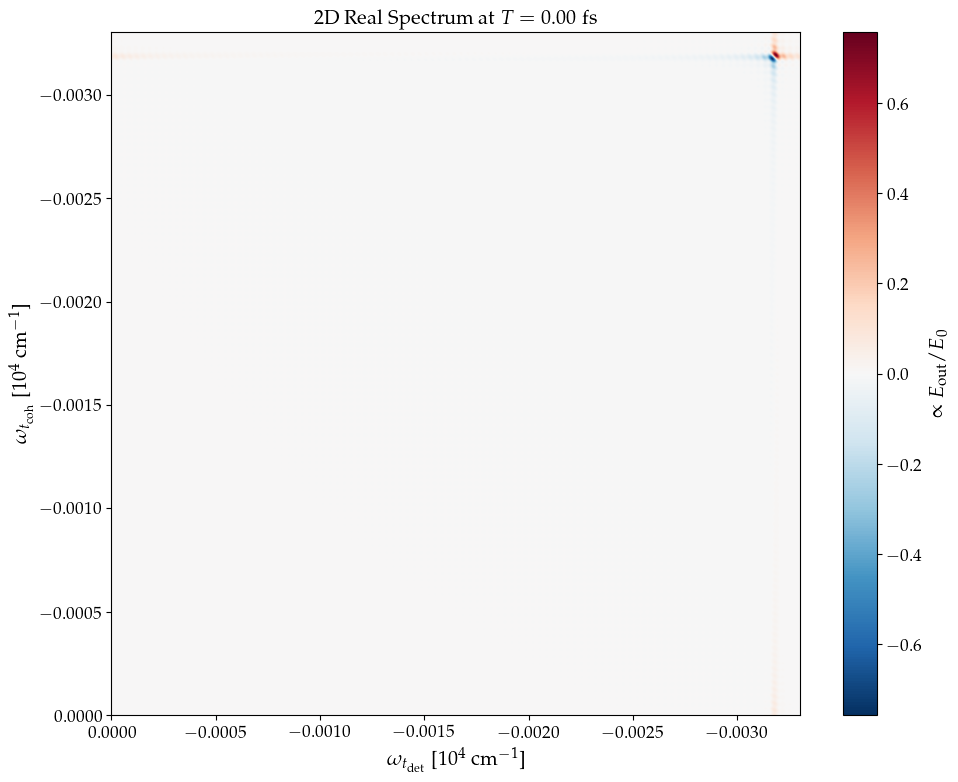

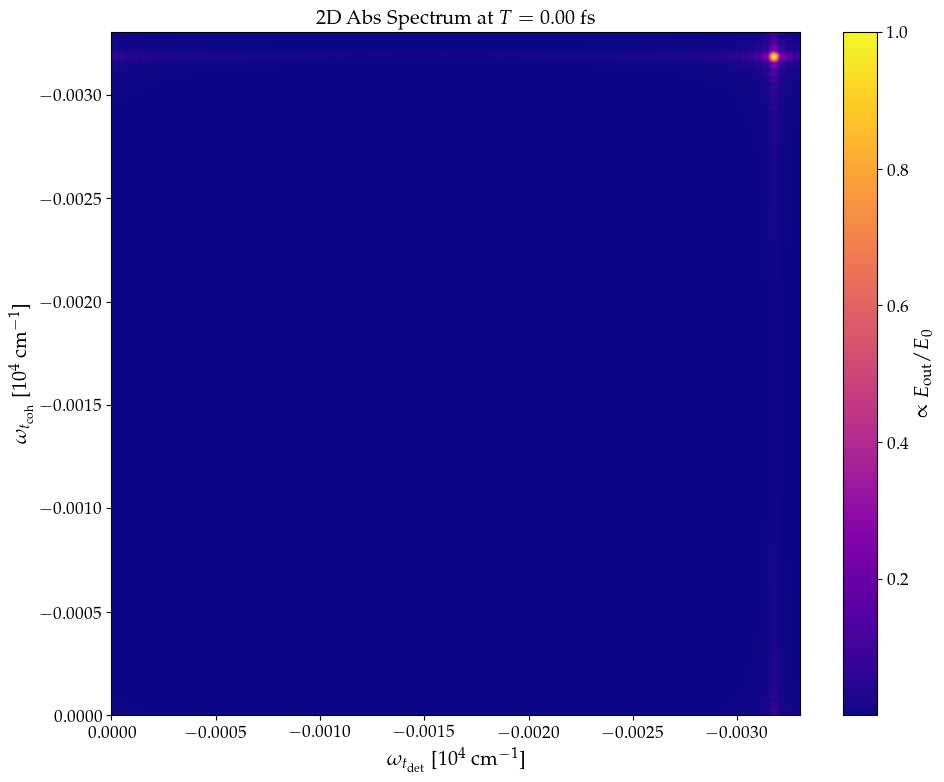

In [12]:
from qspectro2d.spectroscopy.post_processing import extend_time_axes


x = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100)

data = np.zeros((len(y), len(x)), dtype=complex)

### Add a decaying sine function along the diagonal
for i in range(len(y)):
    for j in range(len(x)):
        # Calculate normalized diagonal position (0 to 1)
        diag_pos_y = i / (len(y) - 1)  # normalized y position
        diag_pos_x = j / (len(x) - 1)  # normalized x position
        
        # Only fill values near the diagonal
        if abs(diag_pos_y - diag_pos_x) < 1:  # within 10% of diagonal
            # Calculate position along diagonal (0 to 1)
            diag_progress = (diag_pos_y + diag_pos_x) / 2
            
            # Create decaying sine wave
            amplitude = np.exp(-3 * diag_progress)  # exponential decay
            frequency = 10000  # oscillation frequency
            phase_shift = 0
            
            # Calculate complex value
            real_part = amplitude * np.sin(frequency * diag_progress + phase_shift)
            imag_part = amplitude * np.cos(frequency * diag_progress + phase_shift)
            
            data[i, j] = real_part + 1j * imag_part


### Plot different components of the original data
components = ["real", "abs"]
"""
for component in components:
    fig = plot_2d_el_field(
        axis_det=x,
        axis_coh=y, 
        data=data,
        
        domain="time",
        component=component,
        t_wait=0.0,
    )
"""    
### Compute 2D FFT using the wavenumber function
x, y, data = extend_time_axes(data, x, y, pad_t_coh=(1, 10), pad_t_det=(1, 10))
freq_x, freq_y, data_fft = compute_2d_fft_wavenumber(x, y, data)

### Plot different components of the FFT data
for component in components:
    fig = plot_2d_el_field(
        axis_det=freq_x,
        axis_coh=freq_y,
        data=data_fft,
        domain="freq",
        component=component,
        t_wait=0.0,
        #section=[(-2,4),(-4,4)]
    )